# FEM Modelling for STEDIN Transformer

In this part, the conducitvity of the core material is modelled as 0. Therefore, there areno eddy current effects.

## Import Packages

In [1]:
using gmsh
using LinearAlgebra
using LaTeXStrings
using Plots
using CSV
using DataFrames
include("../../../lib/Makie_Plots.jl");
using .Makie_Plots
include("../../../lib/FEM_Transient_VoltageFed_Tri_1e.jl");
using .FEM_Transient_VoltageFed_Tri_1e
include("../../../lib/Mesh_Data_stedin.jl");
using .Mesh_Data_stedin
include("../../../lib/Save_VTK.jl");
using .Save_VTK

## Julia code

In [2]:
gmsh.initialize()

## Read mesh from file
gmsh.open("../mesh/stedin_transformer.msh")

mesh_data = get_mesh_data_tri_1e(gmsh)

Ip = 17.54;   # Primary peak phase current
Is = 777.62;  # Secondary peak phase current
Vp = 15202.40;   # Primary peak phase voltage
Vs = 342.93;     # Secondary peak phase voltage
Np = 266;
Ns = 6;
Rext = 1e-4;
Lext = 1e-4;

omega = 2*pi*50;  # Frequency

# HV winding dimensions (all phases left/right are identical)
wwhv = 3e-2;
hwhv = 74e-2;
mwhv = 14.75e-2;
Awhv = wwhv * hwhv;

# LV winding dimensions (all phases left/right are identical)
wwlv = 2e-2;
hwlv = 74e-2;
mwlv = 11.25e-2;
Awlv = wwlv * hwlv;

# Calculate turn density in the windings
Tp = Np / Awhv;
Ts = Ns / Awlv;

# Specify time start, end and step
init_time = 0
final_time = 1*(2*pi/omega)
dt = (final_time-init_time) / 100
time_steps = Vector(init_time:dt:final_time)

# Source turn density T
# One term for each of the windings, with a positive and negative part
sourcefunction(group_id) = [Ts*(1*(group_id==11))  -Ts*(1*(group_id==12))];
sourceperelement = map(sourcefunction, mesh_data.e_group);

# Source voltage V
# One term for each of the windings, with a positive and negative part
coil_voltage = [Vs; Vs];

# External resistance Rext
# One term for each of the windings, with a positive and negative part
ext_resistance = Rext*[1; 1];

# External resistance Rext
# One term for each of the windings, with a positive and negative part
ext_inductance = Lext*[1; 1];

# Relative permeability model
mu0 = 4e-7 * pi;
mur = 2.5e4;       # Relative permeability of the core
reluctivityfunction(group_id) = (1 / mu0) + (1/(mu0*mur) - 1/mu0) * (group_id == 2)
reluctivityperelement = map(reluctivityfunction, mesh_data.e_group);

# Conductivity
conductivityfunction(group_id) = 0;
conductivityperelement = map(conductivityfunction, mesh_data.e_group);

# Handle the boundary conditions
bnd_node_ids, _ = gmsh.model.mesh.getNodesForPhysicalGroup(1, 1);

# Calculate the vector potential
u = fem(mesh_data, sourceperelement, reluctivityperelement, conductivityperelement, omega, bnd_node_ids, coil_voltage, ext_resistance, ext_inductance, time_steps);

# Post-process for magnetic field and current density
Bx, By, B, Hx, Hy, H, mag_energy = post_process(mesh_data, u, reluctivityperelement, time_steps);

# # Contour plot of the magnetic flux density
# plot_surface_tri_1e(norm.(B), "single_phase_stedin_transformer_B_plot_without_eddy", gmsh)
# # Contour plot of the magnetic field strength
# plot_surface_tri_1e(norm.(H), "single_phase_stedin_transformer_H_plot_without_eddy", gmsh)
# # Contour plot of the magnetic energy
# plot_surface_tri_1e(norm.(mag_energy), "single_phase_stedin_transformer_mag_energy_plot_without_eddy", gmsh)

# # Save as VTK file for Paraview visualization
# save_vtk(mesh_data, norm.(u), norm.(B), norm.(H), norm.(mag_energy), reluctivityperelement, "single_phase_stedin_transformer_without_eddy")

gmsh.finalize()

Info    : Reading '../mesh/stedin_transformer.msh'...
Info    : 168 entities
Info    : 10385 nodes
Info    : 20768 elements
Info    : Done reading '../mesh/stedin_transformer.msh'


In [3]:
u_wave = [u_curr[5000] for u_curr in u];
Bx_wave = [Bx_curr[5000] for Bx_curr in Bx];
By_wave = [By_curr[5000] for By_curr in By];
B_wave = [B_curr[5000] for B_curr in B];
Hx_wave = [Hx_curr[5000] for Hx_curr in Hx];
Hy_wave = [Hy_curr[5000] for Hy_curr in Hy];
H_wave = [H_curr[5000] for H_curr in H];
mag_energy_wave = [mag_energy_curr[5000] for mag_energy_curr in mag_energy];

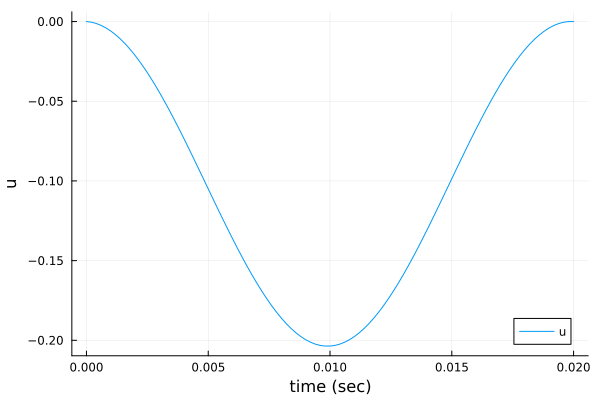

In [4]:
plot(time_steps, real(u_wave), label = "u")
xlabel!("time (sec)")
ylabel!("u")

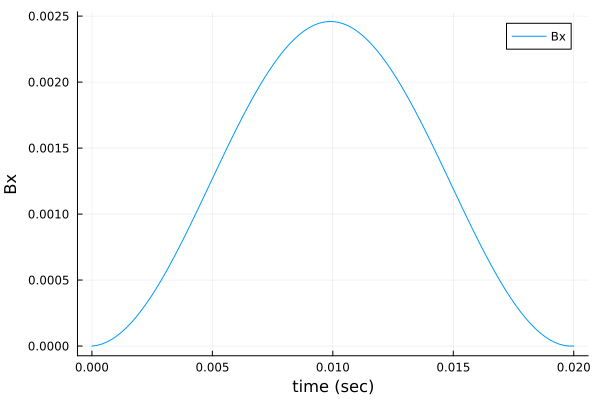

In [5]:
plot(time_steps, real(Bx_wave), label = "Bx")
xlabel!("time (sec)")
ylabel!("Bx")

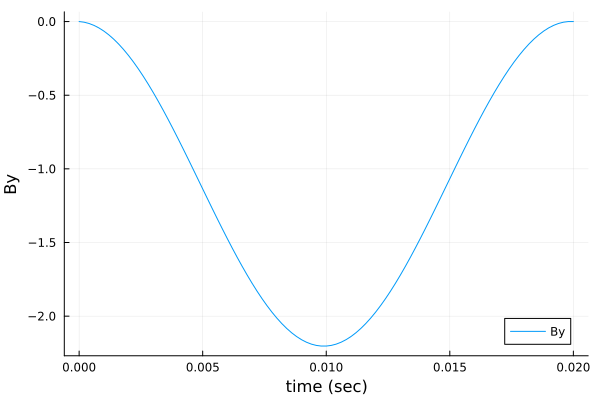

In [6]:
plot(time_steps, real(By_wave), label = "By")
xlabel!("time (sec)")
ylabel!("By")

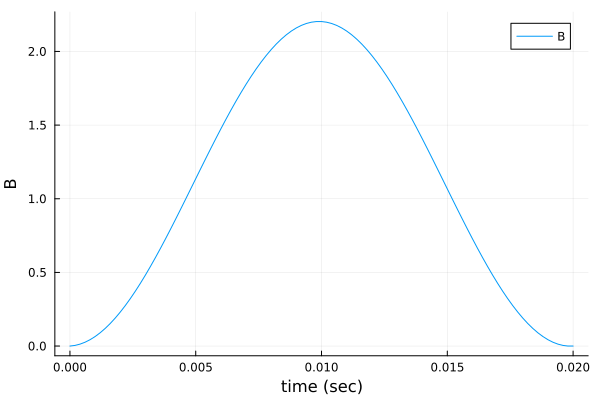

In [7]:
plot(time_steps, real(B_wave), label = "B")
xlabel!("time (sec)")
ylabel!("B")

In [8]:
Bx_mat = DataFrame(real(hcat(Bx...)), :auto)
CSV.write("../csv/single_phase_stedin_transformer_Bx_trasient.csv", Bx_mat)
By_mat = DataFrame(real(hcat(By...)), :auto)
CSV.write("../csv/single_phase_stedin_transformer_By_trasient.csv", By_mat)
B_mat = DataFrame(real(hcat(B...)), :auto)
CSV.write("../csv/single_phase_stedin_transformer_B_trasient.csv", B_mat)
Hx_mat = DataFrame(real(hcat(Hx...)), :auto)
CSV.write("../csv/single_phase_stedin_transformer_Hx_trasient.csv", Hx_mat)
Hy_mat = DataFrame(real(hcat(Hy...)), :auto)
CSV.write("../csv/single_phase_stedin_transformer_Hy_trasient.csv", Hy_mat)
H_mat = DataFrame(real(hcat(H...)), :auto)
CSV.write("../csv/single_phase_stedin_transformer_H_trasient.csv", H_mat)
mag_energy_mat = DataFrame(real(hcat(mag_energy...)), :auto)
CSV.write("../csv/single_phase_stedin_transformer_mag_energy_trasient.csv", mag_energy_mat)

"../csv/single_phase_stedin_transformer_mag_energy_trasient.csv"

### STEDIN Transformer : Magnetic field density
<img src="../img/single_phase_stedin_transformer_B_plot_voltagefed.png">

### STEDIN Transformer : Magnetic field strength
<img src="../img/single_phase_stedin_transformer_H_plot_voltagefed.png">

### STEDIN Transformer : Magnetic energy
<img src="../img/single_phase_stedin_transformer_mag_energy_plot_voltagefed.png">